In [86]:
from qiskit_aer import AerSimulator, Aer
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import MCMT
import time
import hashlib
from math import sqrt, pi
from qiskit.quantum_info import Statevector, Operator, DensityMatrix
from qiskit.circuit import (
    Parameter, QuantumCircuit, ClassicalRegister, QuantumRegister
)
from qiskit.primitives import BackendSampler, StatevectorSampler, Sampler
from qiskit.circuit.library import PhaseGate, QFT
import math
import numpy as np
from random import randint
from qiskit.visualization import plot_histogram

In [87]:
def generate_U(m,thetas):
  U = QuantumCircuit(m, name="U")  # create circuit for our unitary
  U_matrix = np.identity(2**m, dtype=complex) # start out as identity matrix
  for i in range(len(thetas)):
    U_matrix[i, i] = np.exp(2 * np.pi * 1j * thetas[i])
  U.unitary(Operator(U_matrix), range(m))  # apply this unitary gate to first m qubits
  return U.to_gate()

def U_repeated(m,thetas,k):
  # creates a controlled gate that repeats U (k-many times) based on qubit 0
  U_pow = QuantumCircuit(m, name="$U^" + str(k) + "$")
  U_pow.append(generate_U(m,thetas), range(m))
  U_pow.repeat(k)
  U_pow = U_pow.control(1)
  return U_pow

def phase_oracle(m, thetas, n):
  # n is the number of control qubits and m is the qubits of the eigenvector
  po = QuantumCircuit(m+n, name="Phase Oracle")
  U_gate = generate_U(m, thetas)
  for k in range(n):
        U_k_gate = U_gate.power(2**k)
        po.append(U_k_gate.control(), [m + k] + list(range(m)))
  return po

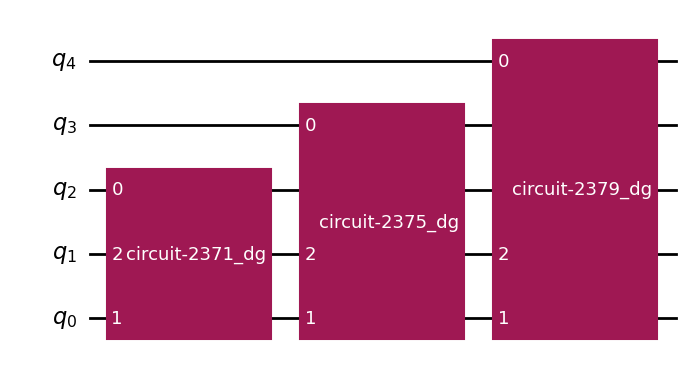

In [88]:
phase_oracle(2, [1,1], 3).decompose().draw(output='mpl', reverse_bits=True)

In [89]:
def get_metric(counts, metric, granularity):
  # counts is a dictionary in the form {value : num_counts}
  # return the value corresponding to the metric
  if metric == "mode":
    return max(counts, key=counts.get)
  elif metric == "mean":
    total_counts = sum(counts.values())
    mean = sum(value * count for value, count in counts.items()) / total_counts
    return mean
  elif metric == "2d_avg":
    total_measurements = sum(counts.values())
    avg_x = 0
    avg_y = 0

    # max_angle = (2**granularity - 1) / (2**granularity) * 2 * math.pi

    for j, count in counts.items():
        theta = (j / (2**granularity)) * 2 * np.pi

        x = np.cos(theta)
        y = np.sin(theta)

        weighted_x = x * count / total_measurements
        weighted_y = y * count / total_measurements

        avg_x += weighted_x
        avg_y += weighted_y

    avg_theta = math.atan2(avg_y, avg_x)
    if avg_theta < 0:
        avg_theta += 2 * np.pi

    return avg_theta * granularity
  else:
    # TODO optional: implement a metric of your own here
    print("invalid metric provided!")
    return -1

In [90]:
def phase_estimation(granularity, thetas, metric="mode", num_shots=500, draw_diagram=False):
  # granularity is the "n", or number of qubits j is stored on
  qreg_j = QuantumRegister(granularity, "q_j")
  qreg_eigenvector = QuantumRegister(1, "q_eigen")
  creg_j = ClassicalRegister(granularity, "c_j")

  measured_thetas = []  # contains data in the form (expected, measured) for each eigenvector
  for eigenvector in range(2):  # for each of our eigenvectors |0> and |1>
    qc = QuantumCircuit(qreg_eigenvector, qreg_j, creg_j)

    # TODO: initialize eigenvector
    if eigenvector == 1:
      qc.x(qreg_eigenvector[0])

    # TODO: build phase estimation circuit
    qc.h(qreg_j)
    phase_oracle_gate = phase_oracle(1, thetas, granularity)
    qc.append(phase_oracle_gate, qreg_eigenvector[:] + qreg_j[:])
    qc.append(QFT(granularity, inverse=True), qreg_j[:])
    qc.measure(qreg_j, creg_j)

    sampler = StatevectorSampler() #Don't extend circuit down to eigenvector
    job = sampler.run([qc,], shots=num_shots)
    counts = job.result()[0].data.c_j.get_int_counts()
    measured_j = get_metric(counts, metric, granularity)
    # print(counts, measured_j)
    measured_theta = measured_j / 2**granularity
    measured_thetas.append(measured_theta)
  # print(measured_thetas)
  circuit_diagram = qc.draw(output='mpl', reverse_bits=True)
  return circuit_diagram if draw_diagram else measured_thetas

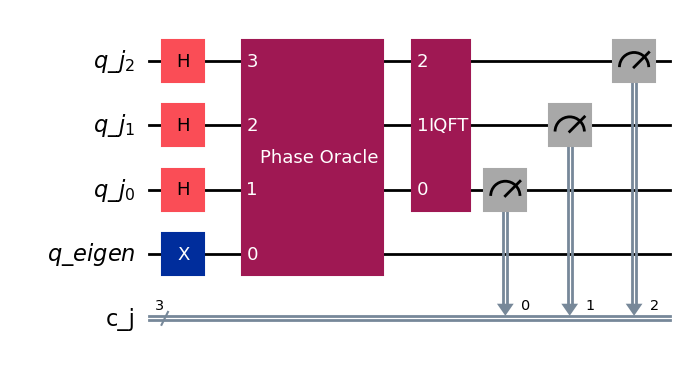

In [91]:
phase_estimation(granularity = 3, thetas=[1,1], draw_diagram=True, metric="2d_avg")

In [92]:
phase_estimation(granularity=5, thetas=[0.7, 0.99], metric="2d_avg")

[0.6847549406514566, 0.9769550839386604]

In [125]:
def initialize_qubits(qc, n, m):
    qc.h(range(n)) # apply hadamard gates
    qc.x(n+m-1) # set qubit to 1

def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits), inverse=True),
                         measurement_qubits)

def measure(qc, n):
    qc.measure(n, n)

def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def modular_exponentiation(qc, n, m, a):
    for x in range(n):
        exponent = 2**x
        qc.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))

def period_finder(n, m, a):
    
    # set up quantum circuit
    qc = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(qc, n, m)
    qc.barrier()

    # apply modular exponentiation
    modular_exponentiation(qc, n, m, a)
    qc.barrier()

    # apply inverse QFT
    apply_iqft(qc, range(n))
    qc.barrier()

    # measure the n measurement qubits
    measure(qc, range(n))
    
    return qc

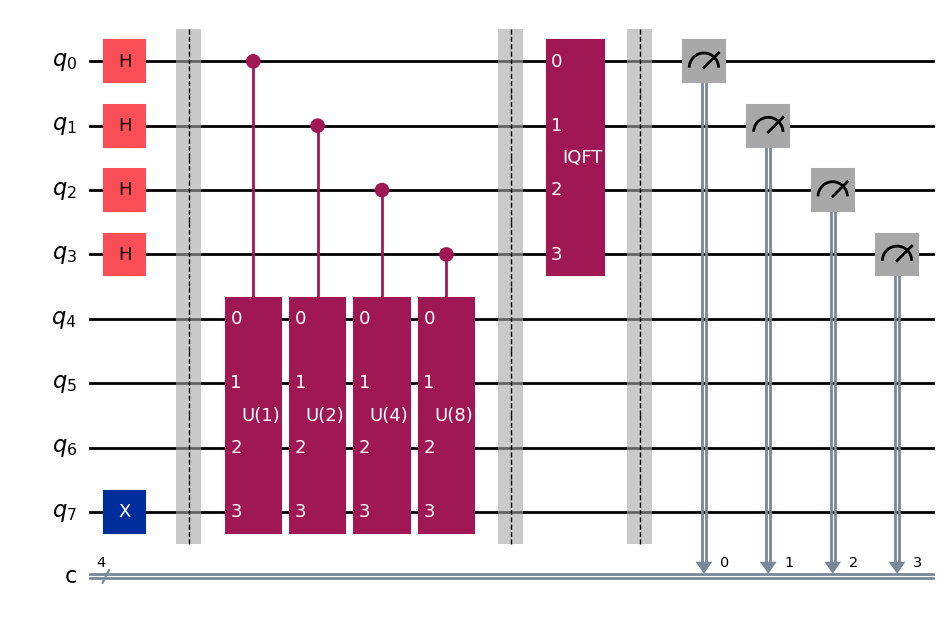

In [126]:
n=4; m=4; N=15
a= 11

qc = period_finder(n,m,a)
qc.draw(output="mpl")

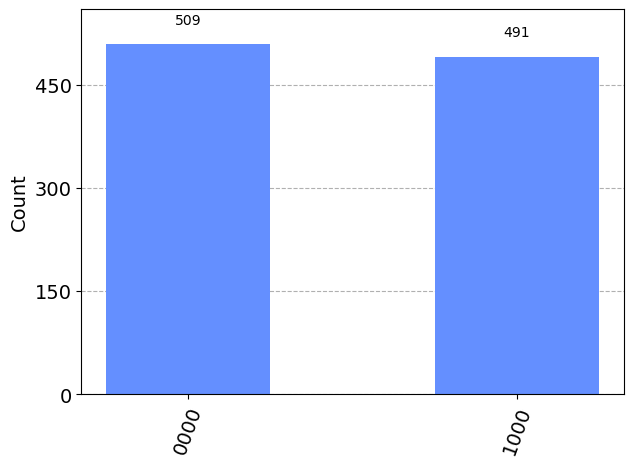

In [127]:
backend = Aer.get_backend("qasm_simulator")
qct = transpile(qc, backend)
counts = backend.run(qct, shots=1000).result().get_counts()

plot_histogram(counts)

In [128]:
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

print("Measured periods:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured periods:	0	1	

In [129]:
from math import gcd


factors = set()

for x in counts_dec:
    guesses = [gcd(int((a ** (measured_value/2))) + 1, N),
               gcd(int((a ** (measured_value/2))) - 1, N)]
    for guess in guesses:
        # ignore trivial factors
        if guess != 1 and guess != N and N % guess == 0:
            factors.add(guess)
print(factors)
if len(factors):
    P = factors.pop()
    Q = factors.pop() if len(factors) else N // P
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

set()
Shor's Algorithm Failed. Choose a different 'a'.
